In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anomaly-detection/Submission.csv
/kaggle/input/anomaly-detection/train.csv
/kaggle/input/anomaly-detection/test.csv


In [2]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_blobs
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [3]:
df_train=pd.read_csv('/kaggle/input/anomaly-detection/train.csv')

In [4]:
df_train.head()

,timestamp,value,is_anomaly,predicted
0,1425008573,42,False,44.072500
1,1425008873,41,False,50.709390
2,1425009173,41,False,81.405120
3,1425009473,61,False,39.950367
4,1425009773,44,False,35.350160


In [5]:
print(df_train.isnull().sum())

timestamp     0
value         0
is_anomaly    0
predicted     0
dtype: int64


In [6]:
df_train['is_anomaly']=df_train['is_anomaly'].replace(False,0).replace(True,1)

Replacing all the false values ie if there are no anomaly as "0" and if there are anomaly ie true as replaced with "1"

In [7]:
print(df_train.head())

    timestamp  value  is_anomaly  predicted
0  1425008573     42           0  44.072500
1  1425008873     41           0  50.709390
2  1425009173     41           0  81.405120
3  1425009473     61           0  39.950367
4  1425009773     44           0  35.350160


In [8]:
print(df_train.describe())

          timestamp         value    is_anomaly     predicted
count  1.583000e+04  15830.000000  15830.000000  15830.000000
mean   1.427383e+09     85.572205      0.049021     71.870715
std    1.370962e+06    321.760918      0.215918     92.450520
min    1.425009e+09      0.000000      0.000000   -281.389070
25%    1.426196e+09     29.000000      0.000000     32.919171
50%    1.427383e+09     47.000000      0.000000     49.771124
75%    1.428570e+09     76.000000      0.000000     75.948052
max    1.429757e+09  13479.000000      1.000000   2716.127200


In [9]:
corr=df_train.corr()

<AxesSubplot:>

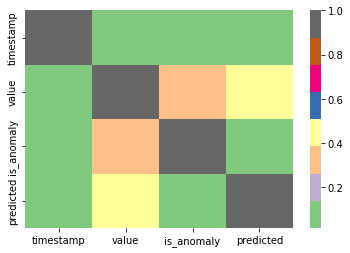

In [10]:
sns.heatmap(corr, 
            xticklabels=df_train.corr().columns.values,
            yticklabels=df_train.corr().columns.values,
            cmap='Accent'
           )

As seen in the heat map, whether the transactions is anomaly or not is highly dependant on Value.
So , here we are considering only Value to make the prediction whether the transaction is an anomaly or not

In [11]:
print(df_train['is_anomaly'])

0        0
1        0
2        0
3        0
4        0
        ..
15825    0
15826    0
15827    0
15828    0
15829    0
Name: is_anomaly, Length: 15830, dtype: int64


<AxesSubplot:xlabel='predicted', ylabel='value'>

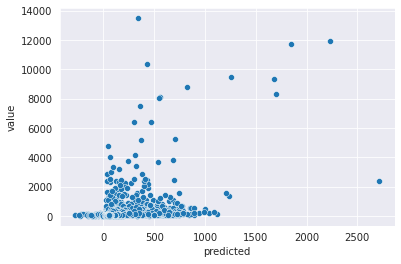

In [12]:
sns.set_style("darkgrid")
sns.scatterplot(x=df_train['predicted'], y=df_train['value'])

<AxesSubplot:xlabel='predicted', ylabel='Count'>

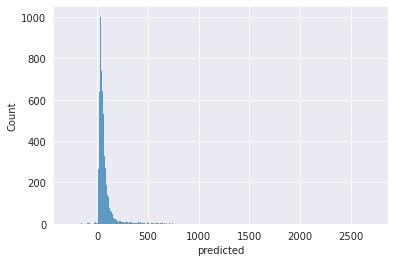

In [13]:
sns.histplot(x='predicted',data=df_train)

<AxesSubplot:xlabel='value', ylabel='Count'>

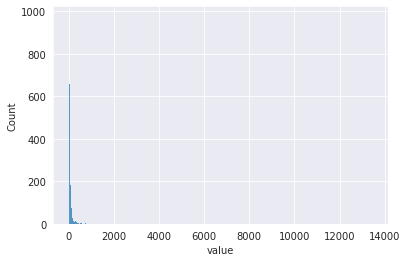

In [14]:
sns.histplot(x='value',data=df_train)

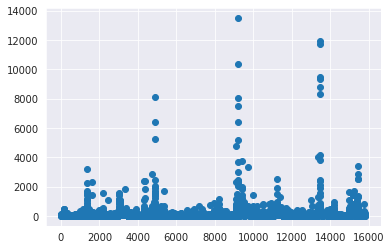

In [15]:
plt.scatter(range(15830),df_train['value'])

In [16]:
#Determine the number of anomalous transactions in the dataset

print("Total No of Transactions:",len(df_train))

Fraud = df_train[df_train['is_anomaly']==True]
print("No of Anomalous Transactions:",len(Fraud))

Valid = df_train[df_train['is_anomaly']==False]
print("No of Valid Transactions:",len(Valid))

outlier_fraction = len(Fraud)/float(len(df_train))
valid_fraction = len(Valid)/float(len(df_train))
print("Percentage of Anomalous Transactions:",round((outlier_fraction*100),3))
print("Percentage of Valid Transactions:",round((valid_fraction*100),3))

Total No of Transactions: 15830
No of Anomalous Transactions: 776
No of Valid Transactions: 15054
Percentage of Anomalous Transactions: 4.902
Percentage of Valid Transactions: 95.098


<AxesSubplot:xlabel='is_anomaly', ylabel='count'>

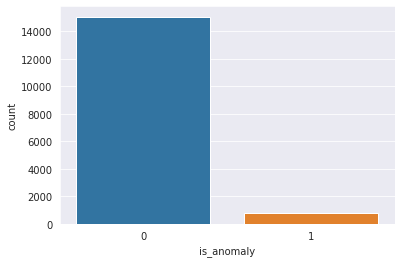

In [17]:
sns.countplot(x='is_anomaly',data=df_train)

In [18]:
df_train['is_anomaly'].value_counts()

0    15054
1      776
Name: is_anomaly, dtype: int64

From the above plot we can see that the number of anomaly is very less. This is an imbalanced data set. But , this imbalance in the dataset is expected can be handled by the following algorithm itself.

In [19]:
X_train = df_train.drop(columns=['is_anomaly'],inplace=False,axis=1)
print(X_train)


        timestamp  value  predicted
0      1425008573     42  44.072500
1      1425008873     41  50.709390
2      1425009173     41  81.405120
3      1425009473     61  39.950367
4      1425009773     44  35.350160
...           ...    ...        ...
15825  1429756073     44  53.624115
15826  1429756373     45  59.752296
15827  1429756673     48  52.147630
15828  1429756973     26  58.007545
15829  1429757273     38  59.144700

[15830 rows x 3 columns]


In [20]:
y_train=df_train['is_anomaly']
print(y_train)

0        0
1        0
2        0
3        0
4        0
        ..
15825    0
15826    0
15827    0
15828    0
15829    0
Name: is_anomaly, Length: 15830, dtype: int64


In [21]:
print(X_train.shape)
print(y_train.shape)

(15830, 3)
(15830,)


In [22]:
# Define a random state 
state = np.random.RandomState(42)
X_outliers = state.uniform(low=0, high=1, size=(X_train.shape[0], X_train.shape[1]))

In [23]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X_train), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',novelty=False,
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Novelty Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',novelty=True,
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1),
    "XGBClassifier":XGBClassifier(learning_rate=1, n_estimators=1300,eta = 0.7, max_depth= 3,  objective= 'multi:softprob',  num_class= 3)
}

In [24]:

for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_train)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X_train)
        y_pred = clf.predict(X_train)
    elif clf_name == "Novelty Local Outlier Factor":
        clf.fit(X_train)
        y_pred = clf.predict(X_train)
        scores_prediction = clf.negative_outlier_factor_  
    elif clf_name == "XGBClassifier":
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_train)
    else:    
        clf.fit(X_train)
        scores_prediction = clf.decision_function(X_train)
        y_pred = clf.predict(X_train)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y_train).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y_train,y_pred))
    print("Classification Report :")
    print(classification_report(y_train,y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_train, y_pred))

Isolation Forest: 1026
Accuracy Score :
0.9351863550221099
Classification Report :
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     15054
           1       0.34      0.34      0.34       776

    accuracy                           0.94     15830
   macro avg       0.65      0.65      0.65     15830
weighted avg       0.94      0.94      0.94     15830

Confusion Matrix:
[[14541   513]
 [  513   263]]
Local Outlier Factor: 1244
Accuracy Score :
0.9214150347441566
Classification Report :
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     15054
           1       0.20      0.20      0.20       776

    accuracy                           0.92     15830
   macro avg       0.58      0.58      0.58     15830
weighted avg       0.92      0.92      0.92     15830

Confusion Matrix:
[[14432   622]
 [  622   154]]
Novelty Local Outlier Factor: 1139
Accuracy Score :
0.928048010107391
Classifi

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier: 776
Accuracy Score :
0.9509791535060013
Classification Report :
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     15054
           1       0.00      0.00      0.00       776

    accuracy                           0.95     15830
   macro avg       0.48      0.50      0.49     15830
weighted avg       0.90      0.95      0.93     15830

Confusion Matrix:
[[15054     0]
 [  776     0]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test data Analysis

In [25]:
df_test=pd.read_csv('/kaggle/input/anomaly-detection/test.csv')

In [26]:
df_test.head()

,timestamp,value,predicted
0,1396332000,20.0,20.0
1,1396332300,20.0,20.0
2,1396332600,20.0,20.0
3,1396332900,20.0,20.0
4,1396333200,20.0,20.0


In [27]:
df_test.describe()

,timestamp,value,predicted
count,3.960000e+03,3960.000000,3960.000000
mean,1.396926e+09,42.909050,43.841335
std,3.429894e+05,28.040740,28.315249
min,1.396332e+09,20.000000,3.158210
25%,1.396629e+09,20.000000,20.037745
50%,1.396926e+09,20.480000,22.011872
75%,1.397223e+09,79.904000,79.077084
max,1.397520e+09,79.999969,114.857970


In [28]:
X_test = df_test
print(X_test)


       timestamp     value  predicted
0     1396332000  20.00000  20.000000
1     1396332300  20.00000  20.000000
2     1396332600  20.00000  20.000000
3     1396332900  20.00000  20.000000
4     1396333200  20.00000  20.000000
...          ...       ...        ...
3955  1397518500  20.00384  19.836240
3956  1397518800  20.00384  19.207998
3957  1397519100  20.00384  20.103437
3958  1397519400  20.00384  19.346764
3959  1397519700  20.00384  20.134947

[3960 rows x 3 columns]


In [29]:
# Define a random state 
state = np.random.RandomState(42)
X_outliers = state.uniform(low=0, high=1, size=(X_test.shape[0], X_test.shape[1]))

In [30]:
print(X_test.shape)

(3960, 3)


In [31]:
print(type(X_test))

<class 'pandas.core.frame.DataFrame'>


In [32]:
X_test['value']

0       20.00000
1       20.00000
2       20.00000
3       20.00000
4       20.00000
          ...   
3955    20.00384
3956    20.00384
3957    20.00384
3958    20.00384
3959    20.00384
Name: value, Length: 3960, dtype: float64

In [33]:
clf = XGBClassifier(learning_rate=1, n_estimators=1300,eta = 0.7, max_depth= 3,  objective= 'multi:softprob',  num_class= 3)
clf.fit(X_train,y_train)

[11:22:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.7, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1300, n_jobs=4, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
y_test_pred = clf.predict(X_test)

In [35]:
data={"timestamp":[],"is_anomaly":[]}
for id,pred in zip(df_test["timestamp"].unique(),y_test_pred):
  data["timestamp"].append(id)
  data["is_anomaly"].append(pred)

In [36]:
output=pd.DataFrame(data,columns=["timestamp","is_anomaly"])
output

,timestamp,is_anomaly
0,1396332000,0
1,1396332300,0
2,1396332600,0
3,1396332900,0
4,1396333200,0
...,...,...
3955,1397518500,0
3956,1397518800,0
3957,1397519100,0
3958,1397519400,0


In [37]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
output['is_anomaly'].value_counts()

Your submission was successfully saved!


0    3941
1      19
Name: is_anomaly, dtype: int64